# Heuristicas

In [1]:
import utils
import simulator as sim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List

DATA = "../data/sim.dat"
POWERS = "../data/sim_powers.tsv"

In [2]:
def read_powers() -> pd.DataFrame:
    return pd.read_csv(
        POWERS,
        sep=' ',
        header=None,
        names=["team", "power"],
    )

def read_sim_ranking(path: str):
    powers = read_powers()
    ranking = utils.read_ranking(path)
    ranking["power"] = (ranking.index + 1).map(powers.set_index("team")["power"])
    ranking["team"] = (ranking.index+1)
    return ranking

In [3]:
utils.run(DATA, utils.METHOD_CMM)
utils.run(DATA, utils.METHOD_WP)

CompletedProcess(args=['../src/tp', '../data/sim.dat', '../data/sim.dat1.out', '1'], returncode=0)

In [4]:
utils.analyze_data(DATA)

,team,share,total,wins,participation


In [29]:
# HEURISTICAS
SELECTED = 10

def find(teams: List[sim.Team], t: int) -> sim.Team:
    """busca el equipo en la lista"""
    for team in teams:
        if(team.index == t):
            return team
    
    return None

def lose(g: sim.Game, t: int) -> sim.Game:
    """Hace que el team t pierda"""
    if(g.team1 == t):
        # make 2 win
        g.score1 = 0
        g.score2 = 1
    elif (g.team2 == t):
        # make 1 win
        g.score2 = 0
        g.score1 = 1
    
    return g

def lose_worse(games: List[sim.Game], teams: List[sim.Team]) -> List[sim.Game]:
    """pierde contra la gente peor que el en skill"""
    skill = find(teams, SELECTED).power
    for i in range(len(games)):
        other_idx = -1
        game = games[i]
        if(game.team1 == SELECTED):
            other_idx = game.team2
        elif(game.team2 == SELECTED):
            other_idx = game.team1
        else:
            # no aparece en este juego
            continue
        
        other_skill = find(teams, other_idx).power
        if (other_skill >= skill):
            # es mejor que nosotros, lo dejamos tal cual
            continue

        # hago que pierda
        games[i] = lose(game, SELECTED)
    
    return games

def lose_better(games: List[sim.Game], teams: List[sim.Team]) -> List[sim.Game]:
    """pierde contra la persona peor en skill"""
    skill = find(teams, SELECTED).power
    for i in range(len(games)):
        other_idx = -1
        game = games[i]
        if(game.team1 == SELECTED):
            other_idx = game.team2
        elif(game.team2 == SELECTED):
            other_idx = game.team1
        else:
            # no aparece en este juego
            continue
        
        other_skill = find(teams, other_idx).power
        if (other_skill < skill):
            # es peor que nosotros, perdemos
            continue

        # hago que pierda
        games[i] = lose(game, SELECTED)
    
    return games
    

In [45]:
# iterar e imprimir boxplot
TEAM_COUNT = 10
ITER = 100

heuristics = [
    {"fn": lose_better, "name": "lose_better"},
    {"fn": lose_worse,  "name": "lose_worse"},
    {"fn": None,        "name": "control"},
]

DATA_FMT = "../data/sim.{}.dat"
RANKING_FMT = DATA_FMT+utils.OUT

results = pd.DataFrame(columns=["rating", "ranking", "wins", "heuristic"])

for h_i, h in enumerate(heuristics, start=1):
    data = DATA_FMT.format(h["name"])
    ranks = RANKING_FMT.format(h["name"])
    heuristic = h["fn"]

    for i in tqdm(range(ITER)):
        # perform the simulation
        sim.simulate(
            team_count=TEAM_COUNT,
            heuristic=heuristic,
            matches_output=data,
            matches_output_heuristic=data,
        )

        # create the ranking
        utils.run(data, utils.METHOD_CMM, ranks)

        # read the ranking & analyze the data
        ranking = read_sim_ranking(ranks)
        analyzed_data = utils.analyze_data(data)
        srt = ranking.sort_values("rating", ascending=False)
        results.loc[i*h_i] = [
            # rating
            ranking.set_index("team").at[SELECTED, "rating"],
            # ranking
            srt[srt["team"] == SELECTED].index[0],
            # wins
            analyzed_data.set_index("team").loc[SELECTED].values[2],
            # heuristic
            h["name"]
        ]

print("Done!")

100%|██████████| 100/100 [00:06<00:00, 14.51it/s]

Done!


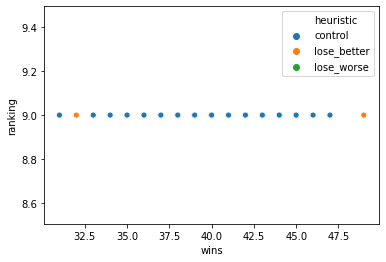

In [54]:
sns.scatterplot(data=results, x="wins", y="ranking", hue="heuristic")

In [14]:
# correr progresivamente
WEEKS = 20
TEAMS = 10
sim.simulate(team_count=TEAMS, weeks=WEEKS)
data = utils.read_mn(DATA).set_index("date")

ratings_by_week = pd.DataFrame()

for week in tqdm(range(1, WEEKS+1)):
    data_til_week = DATA + f".week{week}"
    spliced = data.loc[:week]
    with open(data_til_week, "w") as f:
        print(f"{TEAMS} {spliced.shape[0]}", file=f)

    spliced.to_csv(data_til_week, sep=" ", mode="a", header=False)
    
    utils.run(data_til_week, utils.METHOD_CMM)
    ranking = read_sim_ranking(data_til_week+utils.METHOD_CMM+utils.OUT)
    ranking["week"] = week
    ratings_by_week.append(ranking)

ratings_by_week

100%|██████████| 20/20 [00:00<00:00, 23.36it/s]


,rating,power,team,week
0,0.152688,10.0,1,1
1,0.186022,20.0,2,1
2,0.370968,30.0,3,1
3,0.516129,40.0,4,1
4,0.564516,50.0,5,1
...,...,...,...,...
5,0.599002,60.0,6,20
6,0.624792,70.0,7,20
7,0.659734,80.0,8,20
8,0.690516,90.0,9,20


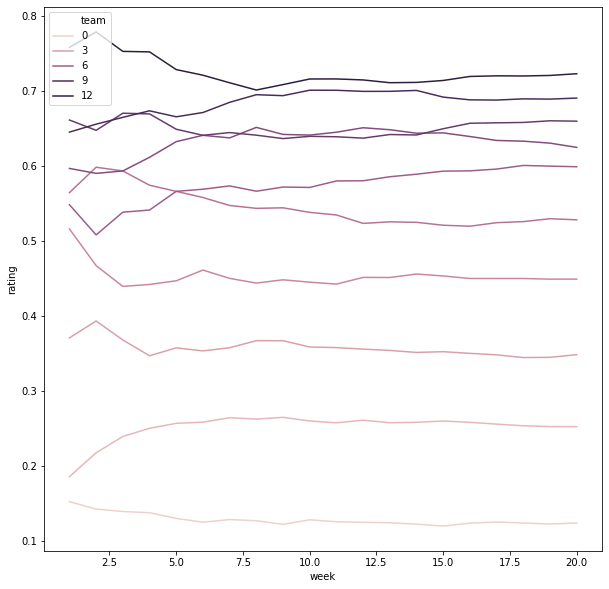

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10)) 
sns.lineplot(data=ratings_by_week, x="week", y="rating", hue="team")

In [ ]:
df = pd.DataFrame({
    "week": [1, 1, 2, 2, 3, 3],
    "other": [2, 2, 4, 4, 5, 5],
})

df.set_index("week").loc[:3]

other = pd.DataFrame({"other": [2, 2, 4, 4, 5, 5]})
other["week"] = 4
cc = pd.concat([df, other])
cc

In [ ]:
def heuristic(games: List[simulator.Game]) -> List[simulator.Game]:
    # calculas cmm
    # run()
    # modificas los partididos segun tu heuristica
    # run()
    # ves el ranking
    